In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os
import tensorboardcolab

Using TensorFlow backend.


**Reading Data**

In [0]:
project_data = pd.read_csv('/content/train_data.csv')
resource_data = pd.read_csv('/content/resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
%load_ext tensorboard

In [5]:
print("Number of data points in resource data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in resource data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [6]:
#https://github.com/mrunal46/Donors-Choose-using-LSTM/blob/master/1_Reference_EDA.ipynb

presence_of_the_numerical_digits = []
for resource in tqdm(project_data['project_resource_summary']):
    number = []
    for data in resource.split():
        if data.isdigit():
            number.append(data)
        else:
            pass
    presence_of_the_numerical_digits.append(len(number))

100%|██████████| 109248/109248 [00:00<00:00, 268852.04it/s]


In [7]:
project_data['presence_of_the_numerical_digits'] = presence_of_the_numerical_digits
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,presence_of_the_numerical_digits
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,0
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,0
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,0


In [0]:
project_data.to_csv('train_data_numeric_feature_added.csv')

**Preprocessing Categorical Features: project_grade_category**

In [9]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [10]:
#we need to remove the spaces, replace the '-' with '_' and convert all the letters to small

# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

**Preprocessing Categorical Features: project_subject_categories**

In [11]:
project_data['project_subject_categories'].value_counts()

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

In [12]:
#emove spaces, 'the' replace '&' with '_', and ',' with '_'
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

**Preprocessing Categorical Features: teacher_prefix**

In [13]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [14]:
#numbwr of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.

project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'].value_counts()

Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [15]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

**Preprocessing Categorical Features: project_subject_subcategories**

In [16]:
project_data['project_subject_subcategories'].value_counts()

Literacy                                        9486
Literacy, Mathematics                           8325
Literature & Writing, Mathematics               5923
Literacy, Literature & Writing                  5571
Mathematics                                     5379
Literature & Writing                            4501
Special Needs                                   4226
Health & Wellness                               3583
Applied Sciences, Mathematics                   3399
Applied Sciences                                2492
Literacy, Special Needs                         2440
Gym & Fitness, Health & Wellness                2264
ESL, Literacy                                   2234
Visual Arts                                     2217
Music                                           1472
Warmth, Care & Hunger                           1309
Literature & Writing, Special Needs             1306
Gym & Fitness                                   1195
Health & Wellness, Special Needs              

In [17]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                                   9486
literacy_mathematics                       8325
literature_writing_mathematics             5923
literacy_literature_writing                5571
mathematics                                5379
literature_writing                         4501
specialneeds                               4226
health_wellness                            3583
appliedsciences_mathematics                3399
appliedsciences                            2492
literacy_specialneeds                      2440
gym_fitness_health_wellness                2264
esl_literacy                               2234
visualarts                                 2217
music                                      1472
warmth_care_hunger                         1309
literature_writing_specialneeds            1306
gym_fitness                                1195
health_wellness_specialneeds               1189
mathematics_specialneeds                   1187
environmentalscience                    

**Preprocessing Categorical Features: school_state**

In [18]:
project_data['school_state'].value_counts()

CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

In [19]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

**Preprocessing Categorical Features: project_title**

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [22]:
project_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [23]:
print("printing some random titles")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random titles
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [0]:
# Combining all the above Statements

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [25]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|██████████| 109248/109248 [00:02<00:00, 42566.26it/s]


In [26]:
print("printing some random titles")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random titles
9 love reading pure pleasure
34 ball
147 needs chromebook


In [0]:
project_data['project_title'] = preprocessed_titles

**Preprocessing Categorical Features: essay**

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [29]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [30]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|██████████| 109248/109248 [00:54<00:00, 1997.88it/s]


In [31]:
print("printing some random essay")
print(9, preprocessed_essays[9])
print('-'*50)
print(34, preprocessed_essays[34])
print('-'*50)
print(147, preprocessed_essays[147])

printing some random essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents work full time students s

In [0]:
project_data['essay'] = preprocessed_essays

**Preprocessing Numerical Values: price**

In [33]:
#https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [0]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [35]:
project_data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

In [0]:
data = pd.read_csv('/content/train_data_numeric_feature_added.csv')
project_data['presence_of_the_numerical_digits'] = data['presence_of_the_numerical_digits']

In [37]:
project_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
project_data.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,presence_of_the_numerical_digits,essay,price,quantity
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,0,students english learners working english seco...,154.60,23
1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,0,students arrive school eager learn polite gene...,299.00,1
2,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,0,true champions not always ones win guts mia ha...,516.85,22
3,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,2016-10-06 21:16:17,grades_prek_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,0,work unique school filled esl english second l...,232.90,4
4,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,2016-07-11 01:10:09,grades_prek_2,math_science,mathematics,interactive math tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,0,second grade classroom next year made around 2...,67.98,4


In [0]:
project_data.to_csv("processed_train_data.csv")

In [0]:
#importing all the required lib
import pandas as pd
import numpy as np 
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,CuDNNLSTM
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras
from sklearn.utils import compute_class_weight
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG, display
import pickle 
import warnings
warnings.filterwarnings("ignore")

In [0]:
dbfile = open('/content/glove_vectors', 'rb')      
db = pickle.load(dbfile)

In [41]:
#REading the dataset
project_data = pd.read_csv('/content/processed_train_data.csv')
project_data.shape

(109248, 21)

In [42]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,presence_of_the_numerical_digits,essay,price,quantity
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,0,students english learners working english seco...,154.6,23
1,1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,0,students arrive school eager learn polite gene...,299.0,1


In [0]:
#merging teacher number of previouly posted projects, presence of the numerical digits, price and quantity into a single feature
project_data.drop(['Unnamed: 0'], axis =1 , inplace = True)
class_label = project_data['project_is_approved']
project_data['remaining_input'] = project_data['teacher_number_of_previously_posted_projects']  +\
                                    project_data['presence_of_the_numerical_digits']  + \
                                    project_data['price'] + project_data['quantity']

In [0]:
project_data['total_txt'] = project_data['project_title'] + ' ' + project_data['essay'] + ' ' + project_data['project_resource_summary']

In [0]:
project_data.replace(to_replace=np.NaN, value= str('nan'),inplace=True)

In [46]:
col = project_data.columns
col

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'presence_of_the_numerical_digits', 'essay', 'price', 'quantity',
       'remaining_input', 'total_txt'],
      dtype='object')

In [0]:
col = ['id','teacher_id','project_submitted_datetime','project_title','project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4','project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved','price', 'quantity',
        'presence_of_the_numerical_digits','essay']

project_data.drop(labels=col,axis =1, inplace=True)

In [0]:
col = project_data.columns

In [0]:
col = ['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories','total_txt',
       'remaining_input']
project_data = project_data[col]

In [0]:
def word_ranking(dataframe):
    col_names = dataframe.columns
    features = []
    #performing train test split
    train,test,y_train,y_test = train_test_split(dataframe, class_label , stratify = class_label, train_size = 0.7)

    train,cv,y_train,y_cv = train_test_split(train,y_train,stratify = y_train,train_size = 0.8)
    for col in col_names[:6]:
        print(col)
        bag_of_words = CountVectorizer(lowercase= False)
        bow_words = bag_of_words.fit_transform(train[col])
        print(bow_words.shape)
        
        #Lets now store the document term matrix in a dictionary.
        freqs = bow_words.sum(axis=0).A1
        index = freqs.argsort()
        words = bag_of_words.get_feature_names()
        
        

        # Assigning Rank to each word based on its freq of occurance. Word with highest freq is assigned rank 1 
        word_rank = dict()
        rank = 1
        for i in index[::-1]:
            k = words[i]
            word_rank[k] = rank
            rank+=1
        features.append(word_rank)
        
        #Every word in each review is replaced by its rank
        rank = [] # list of all the review with words replaced with rank
        for sent in train[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        train[col] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in test[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        test[col] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in cv[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        cv[col] = rank
    return train,test,cv,y_train,y_test,y_cv,features

In [51]:
train,test,cv,y_train,y_test,y_cv,feature_names = word_ranking(project_data)

teacher_prefix
(61178, 5)
school_state
(61178, 51)
project_grade_category
(61178, 4)
project_subject_categories
(61178, 51)
project_subject_subcategories
(61178, 380)
total_txt
(61178, 56870)


In [52]:
print("Shape of the Train dataset: ", train.shape[0])
print("Shape of the Test dataset: ", test.shape[0])
print("Shape of the cv dataset:", cv.shape[0])

Shape of the Train dataset:  61178
Shape of the Test dataset:  32775
Shape of the cv dataset: 15295


In [0]:
#converting class labels to categorical variables
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)

In [0]:
class_wght = compute_class_weight("balanced", classes= np.unique(class_label),y=class_label)

In [55]:
class_wght

array([3.30214001, 0.58921753])

In [56]:
feature_names[4]

{'appliedsciences': 11,
 'appliedsciences_charactereducation': 152,
 'appliedsciences_civics_government': 268,
 'appliedsciences_college_careerprep': 49,
 'appliedsciences_communityservice': 237,
 'appliedsciences_earlydevelopment': 84,
 'appliedsciences_economics': 328,
 'appliedsciences_environmentalscience': 23,
 'appliedsciences_esl': 120,
 'appliedsciences_extracurricular': 87,
 'appliedsciences_financialliteracy': 326,
 'appliedsciences_foreignlanguages': 299,
 'appliedsciences_gym_fitness': 212,
 'appliedsciences_health_lifescience': 38,
 'appliedsciences_health_wellness': 153,
 'appliedsciences_history_geography': 114,
 'appliedsciences_literacy': 39,
 'appliedsciences_literature_writing': 48,
 'appliedsciences_mathematics': 9,
 'appliedsciences_music': 130,
 'appliedsciences_nutritioneducation': 316,
 'appliedsciences_other': 109,
 'appliedsciences_parentinvolvement': 138,
 'appliedsciences_performingarts': 181,
 'appliedsciences_socialsciences': 143,
 'appliedsciences_special

In [0]:
#Creating a matrix with rows as words and columns with 50 dim vectors for each word
def embedding_mat(word_index,embedding_dim = 300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = db.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

**Tokenizing The Text part**

In [58]:
max_review_length = 250
X_train = pad_sequences(train['total_txt'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test = pad_sequences(test['total_txt'], maxlen=max_review_length)
X_cv = pad_sequences(cv['total_txt'], maxlen=max_review_length)
print(X_train.shape)
print(X_train[256])

(61178, 250)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0   374    85   716     1   220    12   130    91   389   330
   892   947  1863   106    53    12     1   405     5   137    68   320
    89     5  2346   163     1   920  2321   550   458  2155    83    40
    22   220   866    91   389  1228   895    34   317     1   137 12746
   188  2149  4302   546   290     1   291   195  1168   486     3   182
  4852    21  1456   546  3791  5733   861  3643   546    59     1     7
  3655  1642     6  1715   692   575  2086  1642    85  1832  1642  8384
   314  3638  1268     5  1339   538  1111     1   692   575  2567  1715
   575  2567   351    53    36     6     1  1284   334  1061    24    30
    16   692   575  2764    91   389   251 10766    24  2472   723    36
    73    64   550   602   227  1456   376   128  2764    93     6  1139
     5  2989  1801    27  3065   259  

**Tokenizing School State**

In [59]:
max_review_length = 1
X_train_school_state = pad_sequences(train['school_state'], maxlen=max_review_length)  
X_test_school_state = pad_sequences(test['school_state'], maxlen=max_review_length)
X_cv_school_state = pad_sequences(cv['school_state'], maxlen=max_review_length)
print(X_test_school_state.shape)
print(X_test_school_state[0])

(32775, 1)
[2]


**Tokenizing the project_grade_category**

In [60]:
max_review_length = 1
X_train_project_grade = pad_sequences(train['project_grade_category'], maxlen=max_review_length)
X_test_project_grade = pad_sequences(test['project_grade_category'], maxlen=max_review_length)
X_cv_project_grade = pad_sequences(cv['project_grade_category'], maxlen=max_review_length)
print(X_train_project_grade.shape)
print(X_train_project_grade[0])

(61178, 1)
[2]


**Tokenizing the project categories**

In [61]:
max_review_length = 1
X_train_project_cat = pad_sequences(train['project_subject_categories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_cat = pad_sequences(test['project_subject_categories'], maxlen=max_review_length)
X_cv_project_cat = pad_sequences(cv['project_subject_categories'], maxlen=max_review_length)
print(X_train_project_cat.shape)
print(X_train_project_cat[0])

(61178, 1)
[36]


**Tokenizing the project subcategories**

In [62]:
max_review_length = 1
X_train_project_subcat = pad_sequences(train['project_subject_subcategories'], maxlen=max_review_length)  
X_test_project_subcat = pad_sequences(test['project_subject_subcategories'], maxlen=max_review_length)
X_cv_project_subcat = pad_sequences(cv['project_subject_subcategories'], maxlen=max_review_length)
print(X_train_project_subcat.shape)
print(X_train_project_subcat[0])

(61178, 1)
[110]


**Tokenizing the teacher prefix**

In [63]:
max_review_length = 1
X_train_teacher_prefix = pad_sequences(train['teacher_prefix'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_teacher_prefix = pad_sequences(test['teacher_prefix'], maxlen=max_review_length)
X_cv_teacher_prefix = pad_sequences(cv['teacher_prefix'], maxlen=max_review_length)
print(X_train_teacher_prefix.shape)
print(X_test_teacher_prefix[0])

(61178, 1)
[1]


In [64]:
train.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,total_txt,remaining_input
21875,[3],[26],[2],[36],[110],"[4265, 54, 167, 78, 94, 144, 2, 7921, 20774, 1...",74.49
53730,[2],[27],[2],[1],[1],"[1378, 18, 392, 2219, 1, 3, 3, 37, 31, 4435, 3...",94.48
12461,[2],[6],[3],[2],[26],"[142, 7621, 3058, 4167, 1, 19, 161, 75, 4, 62,...",124.49
31005,[1],[19],[3],[31],[74],"[725, 33, 162, 2, 382, 127, 1614, 541, 1032, 3...",141.51
6248,[2],[11],[1],[1],[1],"[4885, 11, 14, 1, 106, 53, 1, 393, 350, 49, 40...",607.99


# **Model 1**

In [0]:
#AUC score
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        stateful=True,
                        name='sklearnAUC' )
    return score


def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 1e-6
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [67]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=56871,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52,output_dim= 2)(input2)
#x2 = SpatialDropout1D(0.3)(x2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
#x3 = SpatialDropout1D(0.3)(x3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
#x4 = SpatialDropout1D(0.3)(x4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
#x5 = SpatialDropout1D(0.3)(x5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
#x6 = SpatialDropout1D(0.3)(x6)
x6 = Flatten()(x6)
#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
#x7 = Flatten()(x7)
#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auc])
#lrate = LearningRateScheduler(step_decay)
print(model.summary())

W0818 07:55:42.802108 139944755865472 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0818 07:55:44.864600 139944755865472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0818 07:55:44.888937 139944755865472 deprecation.py:323] From <ipython-input-65-c99e1f58a26a>:6: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 250, 300)     17061300    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 250, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (I

In [72]:
#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="weights_copy.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
model.fit([X_train,X_train_school_state,X_train_project_grade,X_train_project_cat,X_train_project_subcat,
           X_train_teacher_prefix,train['remaining_input']], y_train, nb_epoch=20,verbose=1,batch_size=256,
          validation_data=([X_cv,X_cv_school_state,X_cv_project_grade,X_cv_project_cat,X_cv_project_subcat,
           X_cv_teacher_prefix,cv['remaining_input']]  , y_cv),callbacks =callbacks_list,class_weight = class_wght )

Train on 61178 samples, validate on 15295 samples
Epoch 1/20
61178/61178 [==============================] - 14s 229us/step - loss: 0.4548 - auc: 0.5462 - val_loss: 0.4585 - val_auc: 0.5815

Epoch 00001: val_auc improved from -inf to 0.58154, saving model to weights_copy.best.hdf5
Epoch 2/20
61178/61178 [==============================] - 14s 229us/step - loss: 0.4525 - auc: 0.5508 - val_loss: 0.4460 - val_auc: 0.5995

Epoch 00002: val_auc improved from 0.58154 to 0.59953, saving model to weights_copy.best.hdf5
Epoch 3/20
61178/61178 [==============================] - 14s 231us/step - loss: 0.4450 - auc: 0.5654 - val_loss: 0.4341 - val_auc: 0.6428

Epoch 00003: val_auc improved from 0.59953 to 0.64283, saving model to weights_copy.best.hdf5
Epoch 4/20
61178/61178 [==============================] - 14s 232us/step - loss: 0.4318 - auc: 0.6218 - val_loss: 0.4227 - val_auc: 0.6967

Epoch 00004: val_auc improved from 0.64283 to 0.69671, saving model to weights_copy.best.hdf5
Epoch 5/20
61178/

In [0]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=56871,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52,output_dim= 2)(input2)
#x2 = SpatialDropout1D(0.3)(x2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
#x3 = SpatialDropout1D(0.3)(x3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
#x4 = SpatialDropout1D(0.3)(x4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
#x5 = SpatialDropout1D(0.3)(x5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
#x6 = SpatialDropout1D(0.3)(x6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
#x7 = Flatten()(x7)
#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auc])
model.load_weights("/content/weights_copy.best.hdf5")

In [74]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test,X_test_school_state,X_test_project_grade,X_test_project_cat,X_test_project_subcat,
           X_test_teacher_prefix,test['remaining_input']])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv,X_cv_school_state,X_cv_project_grade,X_cv_project_cat,X_cv_project_subcat,
           X_cv_teacher_prefix,cv['remaining_input']])))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train,X_train_school_state,X_train_project_grade,X_train_project_cat,X_train_project_subcat,
           X_train_teacher_prefix,train['remaining_input']])))

Auc for test data: 0.760
Auc for CV data: 0.763
Auc for train data: 0.791


![Model 1 Train](M1_1.jpg)

![Model 1 Val](M1_1_val.jpg)

# Model 2

**Selecting the Top features based on IDF values for the Text part of the project_data**

In [77]:
#Reading the dataset
project_data = pd.read_csv('processed_train_data.csv')
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,presence_of_the_numerical_digits,essay,price,quantity
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,0,students english learners working english seco...,154.60,23
1,1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,0,students arrive school eager learn polite gene...,299.00,1
2,2,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,0,true champions not always ones win guts mia ha...,516.85,22


In [0]:
#combining teacher number of previously posted projects, presence of the numberical digits price and quantity into a single feature
project_data.drop(['Unnamed: 0'], axis =1 , inplace = True)
class_label = project_data['project_is_approved']
project_data['remaining_input'] = project_data['teacher_number_of_previously_posted_projects']  +\
                                    project_data['presence_of_the_numerical_digits']  + \
                                    project_data['price'] + project_data['quantity']

In [0]:
#train test split
train,test,y_train,y_test = train_test_split(project_data, class_label , stratify = class_label, train_size = 0.7)

In [0]:
train,cv,y_train,y_cv = train_test_split(train,y_train,stratify = y_train,train_size = 0.8)

In [81]:
print("Shape of the Train dataset: ", train.shape[0])
print("Shape of the Test dataset: ", test.shape[0])
print("Shape of the CV Dataset:", cv.shape[0])

Shape of the Train dataset:  61178
Shape of the Test dataset:  32775
Shape of the CV Dataset: 15295


In [0]:
# converting the class labels to one hot encoding for keras model evaluation
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)

In [0]:
# reading the pre trained word vectors file
dbfile = open('/content/glove_vectors', 'rb')      
db = pickle.load(dbfile)

In [0]:
#creating a matrix of word as rows and columns as 50 dmin vectors of words
def embedding_mat(word_index,embedding_dim = 300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector =db.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

Text(0, 0.5, 'IDF score')

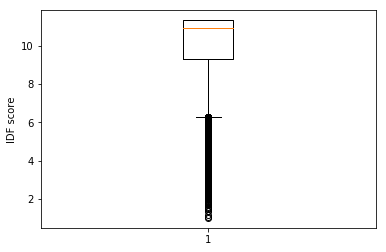

In [88]:
#tfidf vectorization of text data
tfidf = TfidfVectorizer()
data_text = tfidf.fit_transform(train['essay'])
plt.boxplot(tfidf.idf_)
plt.ylabel("IDF score")

In [89]:
print("The 25 percentile of idf score is :", np.percentile(tfidf.idf_,[25]))
print("The 75 percentile of idf score is :",np.percentile(tfidf.idf_,[75]))

The 25 percentile of idf score is : [9.31350907]
The 75 percentile of idf score is : [11.32841209]


In [0]:
feature_idf = zip(tfidf.get_feature_names(),tfidf.idf_)

feature_name = []
for x,y in feature_idf:
    
    if y >=9.31350907 and 11.32841209 :
        feature_name.append(x)
    else:
        pass

In [0]:
#Selecting only those words which have idf values between 25th percentile to 75th percentile
def few_text(df):
    processed_text = []
    for text in df:
        sent = " "
        words = text.split()
        for word in words:
            if word in feature_name:
                sent = ' ' + word
            else:
                pass
        processed_text.append(sent)
    return processed_text

train['processed_essay'] = few_text(train['essay'])
test['processed_essay'] = few_text(test['essay'])
cv['processed_essay'] = few_text(cv['essay'])

train.to_csv("model-train.csv")
test.to_csv("model-test.csv")
cv.to_csv("model-cv.csv")

In [0]:
train = pd.read_csv("model-train.csv")
test = pd.read_csv("model-test.csv")
cv = pd.read_csv("model-cv.csv")

In [0]:
train['total_txt'] = train['project_title'] + ' ' + train['essay'] + ' ' + train['project_resource_summary']
test['total_txt'] = test['project_title'] + ' ' + test['essay'] + ' ' + test['project_resource_summary']
cv['total_txt'] = cv['project_title'] + ' ' + cv['essay'] + ' ' + cv['project_resource_summary']

In [0]:
y_train = train['project_is_approved']
y_test = test['project_is_approved']
y_cv = cv['project_is_approved']

# converting the class labels to one hot encoding for keras model evaluation
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)

In [0]:
def word_ranking(train,test,cv):
    col_names = train.columns
    features = []
    #performing train test split
    
    for col in col_names[:6]:
        print(col)
        bag_of_words = TfidfVectorizer(lowercase= False)
        bow_words = bag_of_words.fit_transform(train[col])
        print(bow_words.shape)
        
        #Lets now store the document term matrix in a dictionary.
        freqs = bow_words.sum(axis=0).A1
        index = freqs.argsort()
        words = bag_of_words.get_feature_names()
        
        

        # Assigning Rank to each word based on its freq of occurance. Word with highest freq is assigned rank 1 
        word_rank = dict()
        rank = 1
        for i in index[::-1]:
            k = words[i]
            word_rank[k] = rank
            rank+=1
        features.append(word_rank)

        #Every word in each review is replaced by its rank
        rank = [] # list of all the review with words replaced with rank
        for sent in train[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        train[col] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in test[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        test[col] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in cv[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        cv[col] = rank
    return train,test,cv,features

In [0]:
col = ['id','teacher_id','project_submitted_datetime','project_title','project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4','project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved','price', 'quantity',
        'presence_of_the_numerical_digits','essay']

train.drop(labels=col,axis =1, inplace=True)
test.drop(labels=col,axis =1, inplace=True)
cv.drop(labels=col,axis =1, inplace=True)

In [0]:
col = train.columns

In [0]:
col = ['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories','total_txt',
       'remaining_input']
train = train[col]
test = test[col]
test = test[col]

In [0]:
train.replace(to_replace=np.NaN, value= str('nan'),inplace=True)
test.replace(to_replace=np.NaN, value= str('nan'),inplace=True)
cv.replace(to_replace=np.NaN, value= str('nan'),inplace=True)

In [100]:
train,test,cv,feature_names =  word_ranking(train,test,cv)

teacher_prefix
(61178, 5)
school_state
(61178, 51)
project_grade_category
(61178, 4)
project_subject_categories
(61178, 50)
project_subject_subcategories
(61178, 384)
total_txt
(61178, 56980)


Tokenizing the Text part

In [101]:
max_review_length = 250
X_train = pad_sequences(train['total_txt'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test = pad_sequences(test['total_txt'], maxlen=max_review_length)
X_cv = pad_sequences(cv['total_txt'], maxlen=max_review_length)
print(X_train.shape)
print(X_train[256])

(61178, 250)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    12    54   669     5    45  2081
   133     1    44    53     2   186  5894    26  1649   154   292  3031
  1337     2   296  3860    45    42   749   292  1915  1912  1380   111
     2    75     1    23    11    49   151    34  7364   195   531     4
  3031     2   114   490  2190   321  2600     4     4  1352   305     2
    30  1814   136    64   425   386  

Tokenizing the school state

In [102]:
max_review_length = 1
X_train_school_state = pad_sequences(train['school_state'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_school_state = pad_sequences(test['school_state'], maxlen=max_review_length)
X_cv_school_state = pad_sequences(cv['school_state'], maxlen=max_review_length)
print(X_test_school_state.shape)
print(X_test_school_state[0])

(32775, 1)
[21]


Tokenizing the project_grade_category

In [103]:
max_review_length = 1
X_train_project_grade = pad_sequences(train['project_grade_category'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_grade = pad_sequences(test['project_grade_category'], maxlen=max_review_length)
X_cv_project_grade = pad_sequences(cv['project_grade_category'], maxlen=max_review_length)
print(X_train_project_grade.shape)
print(X_train_project_grade[0])

(61178, 1)
[1]


Tokenizing the project categories

In [104]:
max_review_length = 1
X_train_project_cat = pad_sequences(train['project_subject_categories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_cat = pad_sequences(test['project_subject_categories'], maxlen=max_review_length)
X_cv_project_cat = pad_sequences(cv['project_subject_categories'], maxlen=max_review_length)
print(X_train_project_cat.shape)
print(X_train_project_cat[0])

(61178, 1)
[1]


Tokenizing the project subcategories

In [105]:
max_review_length = 1
X_train_project_subcat = pad_sequences(train['project_subject_subcategories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_subcat = pad_sequences(test['project_subject_subcategories'], maxlen=max_review_length)
X_cv_project_subcat = pad_sequences(cv['project_subject_subcategories'], maxlen=max_review_length)
print(X_train_project_subcat.shape)
print(X_train_project_subcat[0])

(61178, 1)
[55]


In [106]:
max_review_length = 1
X_train_teacher_prefix = pad_sequences(train['teacher_prefix'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_teacher_prefix = pad_sequences(test['teacher_prefix'], maxlen=max_review_length)
X_cv_teacher_prefix = pad_sequences(cv['teacher_prefix'], maxlen=max_review_length)
print(X_train_teacher_prefix.shape)
print(X_test_teacher_prefix[0])

(61178, 1)
[1]


In [107]:
train.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,total_txt,remaining_input
0,[1],[20],[1],[1],[55],"[225, 5052, 17738, 1535, 66, 5, 303, 21, 1726,...",177.98
1,[1],[20],[3],[1],[32],"[2878, 627, 190, 155, 3083, 59, 1, 400, 120, 2...",289.26
2,[1],[1],[4],[14],[34],"[1680, 3010, 101, 1901, 45, 1, 111, 151, 14, 1...",228.77
3,[2],[5],[3],[15],[78],"[107, 72, 11, 1670, 1, 1470, 89, 278, 2, 860, ...",135.65
4,[2],[8],[2],[2],[5],"[9258, 1204, 193, 1, 347, 361, 1677, 168, 327,...",293.15


In [109]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=56981,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52,output_dim= 2)(input2)
#x2 = SpatialDropout1D(0.3)(x2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
#x3 = SpatialDropout1D(0.3)(x3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
#x4 = SpatialDropout1D(0.3)(x4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
#x5 = SpatialDropout1D(0.3)(x5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
#x6 = SpatialDropout1D(0.3)(x6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
#x7 = Flatten()(x7)
#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auc])
#lrate = LearningRateScheduler(step_decay)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 250, 300)     17094300    input_25[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 250, 300)     0           embedding_22[0][0]               
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_27 (

In [114]:
#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/weights_2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
model.run_eagerly=True
model.fit([X_train,X_train_school_state,X_train_project_grade,X_train_project_cat,X_train_project_subcat,
           X_train_teacher_prefix,train['remaining_input']], y_train, nb_epoch=50,verbose=1,batch_size=256,
          validation_data=([X_cv,X_cv_school_state,X_cv_project_grade,X_cv_project_cat,X_cv_project_subcat,
           X_cv_teacher_prefix,cv['remaining_input']]  , y_cv),callbacks =callbacks_list )

Train on 61178 samples, validate on 15295 samples
Epoch 1/50
61178/61178 [==============================] - 14s 234us/step - loss: 0.4652 - auc: 0.5422 - val_loss: 0.4539 - val_auc: 0.6129

Epoch 00001: val_auc improved from -inf to 0.61294, saving model to /content/weights_2.best.hdf5
Epoch 2/50
61178/61178 [==============================] - 14s 237us/step - loss: 0.4532 - auc: 0.5578 - val_loss: 0.4584 - val_auc: 0.6405

Epoch 00002: val_auc improved from 0.61294 to 0.64049, saving model to /content/weights_2.best.hdf5
Epoch 3/50
61178/61178 [==============================] - 14s 236us/step - loss: 0.4344 - auc: 0.6280 - val_loss: 0.4158 - val_auc: 0.6971

Epoch 00003: val_auc improved from 0.64049 to 0.69710, saving model to /content/weights_2.best.hdf5
Epoch 4/50
61178/61178 [==============================] - 14s 233us/step - loss: 0.4250 - auc: 0.6598 - val_loss: 0.4044 - val_auc: 0.7153

Epoch 00004: val_auc improved from 0.69710 to 0.71529, saving model to /content/weights_2.bes

In [0]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=56981,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52,output_dim= 2)(input2)
#x2 = SpatialDropout1D(0.3)(x2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
#x3 = SpatialDropout1D(0.3)(x3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
#x4 = SpatialDropout1D(0.3)(x4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
#x5 = SpatialDropout1D(0.3)(x5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
#x6 = SpatialDropout1D(0.3)(x6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
#x7 = Flatten()(x7)
#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
model.load_weights("weights_2.best.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auc])

In [117]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test,X_test_school_state,X_test_project_grade,X_test_project_cat,X_test_project_subcat,
          X_test_teacher_prefix,test['remaining_input']])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv,X_cv_school_state,X_cv_project_grade,X_cv_project_cat,X_cv_project_subcat,
           X_cv_teacher_prefix,cv['remaining_input']])))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train,X_train_school_state,X_train_project_grade,X_train_project_cat,X_train_project_subcat,
           X_train_teacher_prefix,train['remaining_input']])))

Auc for test data: 0.763
Auc for CV data: 0.758
Auc for train data: 0.814


![](M2_1.jpg)

![](M2_1_val.jpg)

# Model 3

In [119]:
#Reading the dataset
project_data = pd.read_csv('processed_train_data.csv')
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,presence_of_the_numerical_digits,essay,price,quantity
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,0,students english learners working english seco...,154.60,23
1,1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,0,students arrive school eager learn polite gene...,299.00,1
2,2,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,0,true champions not always ones win guts mia ha...,516.85,22


In [0]:
# adding feature teacher number of previously posted project, presence of numerical digits, price and quantity
project_data.drop(['Unnamed: 0'], axis =1 , inplace = True)
class_label = project_data['project_is_approved']
project_data['remaining_input'] = project_data['teacher_number_of_previously_posted_projects']  +\
                                    project_data['presence_of_the_numerical_digits']  + \
                                    project_data['price'] + project_data['quantity']

In [0]:
project_data['total_txt'] = project_data['project_title'] + ' ' + project_data['essay'] + ' ' + project_data['project_resource_summary']

In [0]:
project_data.replace(to_replace=np.NaN, value= str('nan'),inplace=True)

In [123]:
col = project_data.columns
col

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'presence_of_the_numerical_digits', 'essay', 'price', 'quantity',
       'remaining_input', 'total_txt'],
      dtype='object')

In [0]:
col = ['id','teacher_id','project_submitted_datetime','project_title','project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4','project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved','price', 'quantity',
        'presence_of_the_numerical_digits','essay']

project_data.drop(labels=col,axis =1, inplace=True)

In [0]:
col = project_data.columns

In [0]:
col = ['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories','total_txt',
       'remaining_input']
project_data = project_data[col]

In [0]:
def word_ranking(dataframe):
    col_names = dataframe.columns
    features = []
    #performing train test split
    train,test,y_train,y_test = train_test_split(dataframe, class_label , stratify = class_label, train_size = 0.7)

    train,cv,y_train,y_cv = train_test_split(train,y_train,stratify = y_train,train_size = 0.8)
    for col in col_names[5:6]:
        print(col)
        bag_of_words = CountVectorizer(lowercase= False)
        bow_words = bag_of_words.fit_transform(train[col])
        print(bow_words.shape)
        
        #Lets now store the document term matrix in a dictionary.
        freqs = bow_words.sum(axis=0).A1
        index = freqs.argsort()
        words = bag_of_words.get_feature_names()
        
        

        # Assigning Rank to each word based on its freq of occurance. Word with highest freq is assigned rank 1 
        word_rank = dict()
        rank = 1
        for i in index[::-1]:
            k = words[i]
            word_rank[k] = rank
            rank+=1
        features.append(word_rank)

        #Every word in each review is replaced by its rank
        rank = [] # list of all the review with words replaced with rank
        for sent in train[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        train[col] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in test[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        test[col] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in cv[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        cv[col] = rank
    return train,test,cv,y_train,y_test,y_cv,features

In [128]:
train,test,cv,y_train,y_test,y_cv,feature_names = word_ranking(project_data)

total_txt
(61178, 56962)


In [129]:
print("Shape of the Train dataset: ", train.shape[0])
print("Shape of the Test dataset: ", test.shape[0])
print("Shape of the CV dataset: ", cv.shape[0])

Shape of the Train dataset:  61178
Shape of the Test dataset:  32775
Shape of the CV dataset:  15295


In [130]:
y_train.shape

(61178,)

In [0]:
#converting class labels to categorical variables
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)

In [132]:
max_review_length = 250
X_train = pad_sequences(train['total_txt'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test = pad_sequences(test['total_txt'], maxlen=max_review_length)
X_cv = pad_sequences(cv['total_txt'], maxlen=max_review_length)
print(X_train.shape)
print(X_train[256])

(61178, 250)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   262   817 32910    19
     1   102     7   676    24    41    22   162     2    28    45    47
   138    93   437   135    47   260    97    66    52    11     1   116
     8   522    97   662   157   962    73     6    61     3   267     2
   213   572   136   188   380  1027  2225   162    28   882     5   801
   149    16   113    72    74   179    62  1042   276     4    72   662
   258    29    71    35    94     2    57   153     1    46   270    37
   541  1742   306    31    19   119   199   104  4215  1678   434   752
  2881  1424   752  2881  1096   208  4227    96     1    46   306    18
    19   119     1     7  8392    88    48   645    88  2368  6244  1321
  1121   817  2274  2012    88   289     1   142  1016    21    29   823
   228    42   253  1214   334    19  

In [133]:
token_sc_stat = CountVectorizer()

# integer encode the documents
school_state_train = token_sc_stat.fit_transform(train['school_state'])
school_state_test = token_sc_stat.transform(test['school_state'])
school_state_cv = token_sc_stat.transform(cv['school_state'])

print(school_state_train.shape)

(61178, 51)


In [134]:
token_grd_cat = CountVectorizer()

# integer encode the documents
project_grade_train = token_grd_cat.fit_transform(train['project_grade_category'])
project_grade_test = token_grd_cat.transform(test['project_grade_category'])
project_grade_cv = token_grd_cat.transform(cv['project_grade_category'])

print(project_grade_train.shape)

(61178, 4)


In [135]:
token_prj_cat = CountVectorizer()

# integer encode the documents
project_cat_train = token_prj_cat.fit_transform(train['project_subject_categories'])
project_cat_test = token_prj_cat.transform(test['project_subject_categories'])
project_cat_cv = token_prj_cat.transform(cv['project_subject_categories'])


print(project_cat_train.shape)

(61178, 50)


In [136]:
token_sub_cat = CountVectorizer()

# integer encode the documents
project_subcat_train = token_sub_cat.fit_transform(train['project_subject_subcategories'])
project_subcat_test = token_sub_cat.transform(test['project_subject_subcategories'])
project_subcat_cv = token_sub_cat.transform(cv['project_subject_subcategories'])

print(project_subcat_train.shape)

(61178, 385)


In [137]:
token_pre = CountVectorizer()

# integer encode the documents
teacher_prefix_train = token_pre.fit_transform(train['teacher_prefix'])
teacher_prefix_test = token_pre.transform(test['teacher_prefix'])
teacher_prefix_cv = token_pre.transform(cv['teacher_prefix'])
print(teacher_prefix_train.shape)

(61178, 5)


In [0]:
input2_train = hstack((school_state_train,project_grade_train,project_cat_train,project_subcat_train,teacher_prefix_train,train['remaining_input'][:,None]))

input2_cv = hstack((school_state_cv,project_grade_cv,project_cat_cv,project_subcat_cv,teacher_prefix_cv,cv['remaining_input'][:,None]))
input2_test = hstack((school_state_test,project_grade_test,project_cat_test,project_subcat_test,teacher_prefix_test,test['remaining_input'][:,None]))

In [0]:
input2_train = hstack((school_state_train,project_grade_train,project_cat_train,project_subcat_train,teacher_prefix_train,train['remaining_input'][:,None]))

input2_cv = hstack((school_state_cv,project_grade_cv,project_cat_cv,project_subcat_cv,teacher_prefix_cv,cv['remaining_input'][:,None]))
input2_test = hstack((school_state_test,project_grade_test,project_cat_test,project_subcat_test,teacher_prefix_test,test['remaining_input'][:,None]))

In [0]:
train=input2_train.todense()
test = input2_test.todense()
cv = input2_cv.todense()

In [0]:
train = np.resize(train,new_shape=(61178,495,1))
test =np.resize(test,new_shape=(32775,495,1))
cv = np.resize(cv,new_shape=(15295,495,1))

In [144]:
train.shape

(61178, 495, 1)

In [0]:
dbfile = open('/content/glove_vectors', 'rb')      
db = pickle.load(dbfile)

In [0]:
#Getting word vectors with 50 dim
def embedding_mat(word_index,embedding_dim = 300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = db.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
#AUC score 
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : roc_auc_score( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        stateful=True,
                        name='sklearnAUC' )
    return score

In [148]:
# input 1
input1 = Input(batch_shape=(None,250))
x1 = Embedding(input_dim=56963,output_dim= 300,weights=[embedding_mat(feature_names[0])],trainable = False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(256,return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input2 = Input(shape=(495,1))
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(input2)
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2 = Flatten()(x2)

# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(300,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.4)(x)
x = Dense(256,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input1,input2], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.adam(lr=0.0006,decay = 1e-4), metrics=[auc])
print(model.summary())

W0818 12:58:56.542916 139944755865472 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 250, 300)     17088900    input_41[0][0]                   
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 495, 1)       0                                            
__________________________________________________________________________________________________
spatial_dropout1d_6 (SpatialDro (None, 250, 300)     0           embedding_36[0][0]               
__________________________________________________________________________________________________
conv1d_1 (

In [150]:
#model fitting
filepath="weights_3.best_copy.hdf5"
model.run_eagerly=True
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
#my_callbacks = [EarlyStopping(monitor='auc', patience=300, verbose=1, mode='max')]
model.fit([X_train,train], y_train, nb_epoch=25,verbose=1,batch_size=256,validation_data=([X_cv,
        cv], y_cv),callbacks = callbacks_list,class_weight = "balanced")

Train on 61178 samples, validate on 15295 samples
Epoch 1/25
61178/61178 [==============================] - 36s 592us/step - loss: 0.7692 - auc: 0.5017 - val_loss: 0.5940 - val_auc: 0.5117

Epoch 00001: val_auc improved from -inf to 0.51169, saving model to weights_3.best_copy.hdf5
Epoch 2/25
61178/61178 [==============================] - 32s 530us/step - loss: 0.6193 - auc: 0.5176 - val_loss: 0.5895 - val_auc: 0.6140

Epoch 00002: val_auc improved from 0.51169 to 0.61399, saving model to weights_3.best_copy.hdf5
Epoch 3/25
61178/61178 [==============================] - 33s 539us/step - loss: 0.5617 - auc: 0.5892 - val_loss: 0.5464 - val_auc: 0.5639

Epoch 00003: val_auc did not improve from 0.61399
Epoch 4/25
61178/61178 [==============================] - 33s 546us/step - loss: 0.5509 - auc: 0.5744 - val_loss: 0.5195 - val_auc: 0.6867

Epoch 00004: val_auc improved from 0.61399 to 0.68672, saving model to weights_3.best_copy.hdf5
Epoch 5/25
61178/61178 [==============================]

In [152]:
# input 1
input1 = Input(batch_shape=(None,250))
x1 = Embedding(input_dim=56963,output_dim= 300,weights=[embedding_mat(feature_names[0])],trainable = False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(256,return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input2 = Input(shape=(495,1))
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(input2)
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2 = Flatten()(x2)

# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(300,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.4)(x)
x = Dense(256,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input1,input2], output)
model.load_weights("weights_3.best_copy.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.adam(lr=0.0006,decay = 1e-4), metrics=[auc])

W0818 13:16:01.463398 139944755865472 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [153]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test,test])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv,cv])))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train,train])))

Auc for test data: 0.762
Auc for CV data: 0.764
Auc for train data: 0.817


![](M3_1.jpg)

![](M3_1_val.jpg)